# Produce overview map and timeline

In [1]:
main_datapath_input = '/home/bene/PhD-docs/80_papers/1_dataset_combination/data/input/'
main_datapath_output = '/home/bene/PhD-docs/80_papers/1_dataset_combination/data/output/'

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

In [3]:
# matplotlib fontsizes
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
time_alt = pd.to_datetime(['2002-01-15', '2020-04-12'])
time_tg_psmsl = pd.to_datetime(['1992-01-15', '2021-12-17'])
time_tg_northsea = pd.to_datetime(['1992-12-31', '2022-01-01'])
time_gnss = pd.to_datetime(['1996-11-03', '2022-03-13'])
time_landsat = pd.to_datetime(['1984-04-30', '2023-02-14'])
time_jarkus = pd.to_datetime(['1992-07-01', '2022-07-01'])

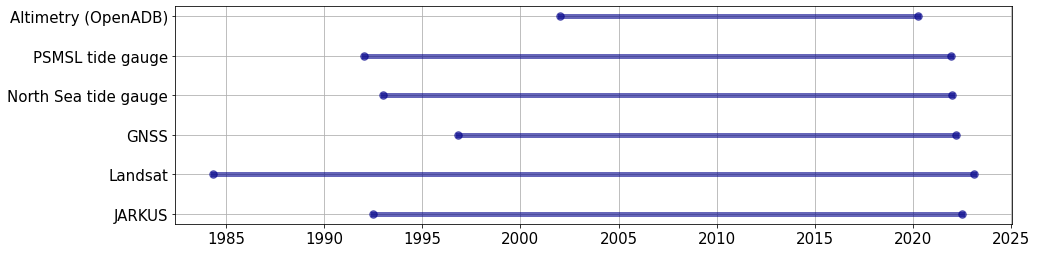

In [6]:
fig, ax = plt.subplots(figsize=(15,4))
lw = 5
ms = 15
color = 'darkblue'
alpha = 0.6
yaxis = np.linspace(5,10,6)
ax.plot(time_alt, [yaxis[5],yaxis[5]], '.-', lw=lw, ms=ms, c=color, alpha=alpha)
ax.plot(time_tg_psmsl, [yaxis[4],yaxis[4]], '.-', lw=lw, ms=ms, c=color, alpha=alpha)
ax.plot(time_tg_northsea, [yaxis[3],yaxis[3]], '.-', lw=lw, ms=ms, c=color, alpha=alpha)
ax.plot(time_gnss, [yaxis[2],yaxis[2]], '.-', lw=lw, ms=ms, c=color, alpha=alpha)
ax.plot(time_landsat, [yaxis[1],yaxis[1]], '.-', lw=lw, ms=ms, c=color, alpha=alpha)
ax.plot(time_jarkus, [yaxis[0],yaxis[0]], '.-', lw=lw, ms=ms, c=color, alpha=alpha)

ax.set_yticks(yaxis,['JARKUS', 'Landsat', 'GNSS', 'North Sea tide gauge', 'PSMSL tide gauge', 'Altimetry (OpenADB)'])
# ax.tick_params(axis='y', direction='in', pad=-220)
ax.grid()
plt.savefig('../99_plot_dump/timeline.png', dpi=300, bbox_inches='tight')

In [7]:
# North sea tide gauge location
tg_lat = 53.420034
tg_lon = 5.351231
tg_loc = gpd.GeoSeries(gpd.points_from_xy([tg_lon], [tg_lat]))
tg_loc = tg_loc.set_crs('EPSG:4326')
tg_loc = tg_loc.to_crs('EPSG:32631')

# PSMSL tide gauge location
psmsl_lat = 53.363
psmsl_lon = 5.220
psmsl_loc = gpd.GeoSeries(gpd.points_from_xy([psmsl_lon], [psmsl_lat]))
psmsl_loc = psmsl_loc.set_crs('EPSG:4326')
psmsl_loc = psmsl_loc.to_crs('EPSG:32631')

# GNSS location
# gnss_lat = 53.36280000 # orig
# gnss_lon = 5.21940000
gnss_lat = 53.361 # moved, so that it does not cover the TG
gnss_lon = 5.218
gnss_loc = gpd.GeoSeries(gpd.points_from_xy([gnss_lon], [gnss_lat])).set_crs('EPSG:4326')
gnss_loc = gnss_loc.to_crs('EPSG:32631')

In [8]:
fn = 'jarkus_transects_EPSG32631_reduced.geojson'
transects = gpd.read_file(main_datapath_output + fn).set_index('name')

In [9]:
datapath_altimetry = '/media/bene/Seagate/PhD-data/2_altimetry/4_OpenADB_Ters/'
data_alt = xr.open_dataset(datapath_altimetry + 'data_alt.nc')

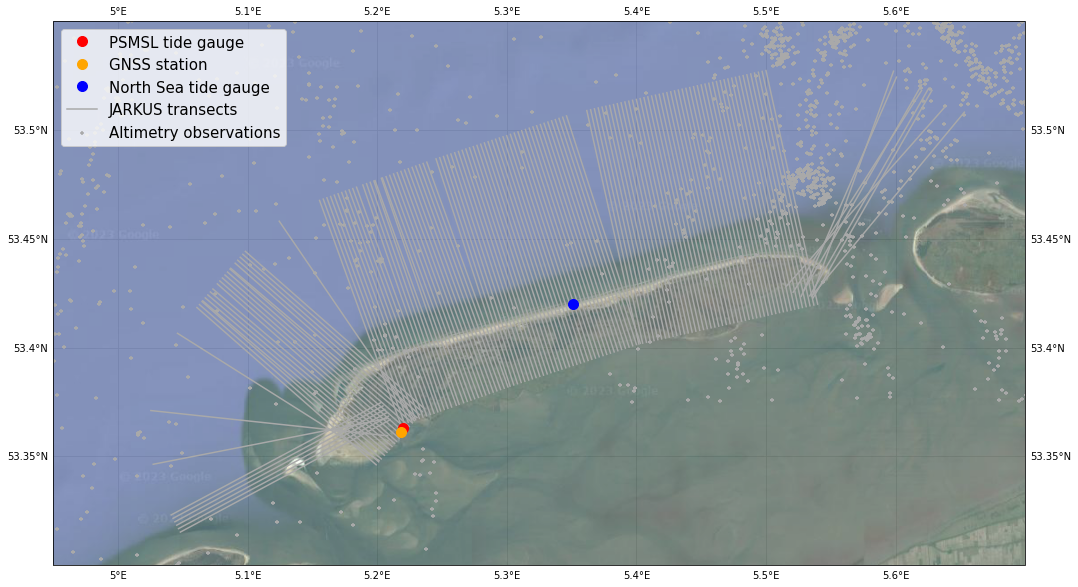

In [10]:
crs_32631 = ccrs.epsg('32631')
request = cimgt.GoogleTiles(style="satellite")
# request = cimgt.OSM()
fig, ax = plt.subplots(figsize=(50,10), subplot_kw=dict(projection=request.crs))
# ax.set_extent([3.95, 7.0, 52.8, 55.55], crs=ccrs.PlateCarree())
ax.set_extent([4.95, 5.7, 53.3, 53.55], crs=ccrs.PlateCarree())
# ax.set_extent([4.8, 6.0, 53.3, 54.0], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, zorder=0, color='lightgrey')
ax.add_image(request, 11, alpha=0.7, zorder=0)

plot_psmsl, = ax.plot(psmsl_loc.x, psmsl_loc.y, 'o', color='red', markersize=10, transform=crs_32631)
plot_gnss, = ax.plot(gnss_loc.x, gnss_loc.y, 'o', color='orange', markersize=10, transform=crs_32631)
plot_northsea, = ax.plot(tg_loc.x, tg_loc.y, 'o', color='blue', markersize=10, transform=crs_32631)
ax.add_geometries(transects.geometry, crs=crs_32631, edgecolor='darkgrey', linewidth=1.5)
plot_altimetry = ax.scatter(data_alt.glon, data_alt.glat, marker='+', s=10, c='darkgrey', transform=ccrs.PlateCarree())

plot_transects = mlines.Line2D([], [], color='darkgrey') # proxy handle

ax.legend([plot_psmsl, plot_gnss, plot_northsea, plot_transects, plot_altimetry],
          ['PSMSL tide gauge', 'GNSS station', 'North Sea tide gauge', 'JARKUS transects', 'Altimetry observations'],
         loc='upper left')

plt.savefig('../99_plot_dump/map_overview.png', dpi=300, bbox_inches='tight')